### CONFIGURATION

In [1]:
import os
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
import random as rand
%matplotlib inline

In [2]:
# Hartwig imports
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import analyseVCF as aVCF
import venn as vn
import chromosomeDefinition as cd

In [3]:
#VCF
#VCF_PATH = "/Users/peterpriestley/hmf/analyses/ensembleRuleTesting/"
VCF_PATH = "/Users/peterpriestley/hmf/analyses/CPCT02010508/"
# BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"
#BED_PATH = "/Users/peterpriestley/hmf/analyses/slices/"
#BED_FILE_NAME = "cosmicCancerCensus.bed" 
#BED_FILE_NAME = "CPCT_Slicing.bed"
USE_BED = True
LOAD_FULL_FILE = True


# TEMP NA12878 VCF CONFIG
#VCF_SAMPLE = "12878"
#VCF_PATH = "/Users/peterpriestley/hmf/analyses/NA12878vsNA12878/Oct28germline/"
#VCF_FILE_NAME = "GIAB12878vGIAB12878-new3.filtered_variants.vcf"

# HEALTH CHECKS
HEALTH_CSV_PATH="/Users/peterpriestley/hmf/analyses/healthCheckAnalysis/"
HEALTH_CSV_FILENAME="healthCheckFile.csv"

In [5]:
# SPECIFY SAMPLES
VCF_SAMPLES=[]
for x in os.listdir(VCF_PATH):
    if x[-10:] == "SLICED.vcf":
        VCF_SAMPLES.append(x)
#VCF_SAMPLES = VCF_SAMPLES[0:1]
VCF_SAMPLES
#VCF_SAMPLES = ['160903_HMFregCPCT_FR10302737_FR10304566_CPCT02070012.filtered_variants_snpEff_snpSift_Cosmicv76_GoNLv5_sliced.vcf']

['170308_HMFregCPCT_FR10248400_FR10244754_CPCT02010508.annotatedSLICED.vcf']

<h3> LOAD VCF

In [6]:
#Load all VCF_SAMPLES to DF
df = pd.DataFrame({})
for VCF_SAMPLE in VCF_SAMPLES:
    patientIDStart = VCF_SAMPLE.find("CPCT0")
    VCF_FILE_NAME = VCF_SAMPLE
    SAMPLE_NAMES = {VCF_SAMPLE[patientIDStart:patientIDStart+12]+'R':'normal',VCF_SAMPLE[patientIDStart:patientIDStart+12]+'T':'tumor'}
    #SAMPLE_NAMES = {'PMC010001R':'normal','PMC010001T':'tumor'}
    if USE_BED:
        bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
        df = pd.concat([df,aVCF.loadVariantsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE[patientIDStart:patientIDStart+12],True,True,bed,LOAD_FULL_FILE)])
        #df = pd.concat([df,aVCF.loadVariantsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,"PMC010001",True,True,bed,LOAD_FULL_FILE)])
    else:
        df = pd.concat([df,aVCF.loadVariantsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE[patientIDStart:patientIDStart+12],True)])

reading vcf file: 170308_HMFregCPCT_FR10248400_FR10244754_CPCT02010508.annotatedSLICED.vcf
reading VCF File line: 1
reading VCF File line: 200001
Number variants loaded: 344830


In [ ]:
#LOAD HEALTH_CHECKS
#hc = pd.read_csv(HEALTH_CSV_PATH + HEALTH_CSV_FILENAME)
#hc = hc[['SAMPLE','TUMOR_PERCENTAGE','TUMOR_TYPE','PIPELINE_VERSION']]
#hc = hc[hc['SAMPLE'].str[12]=="T"]   # only tumor rows
#hc['SAMPLE']=hc['SAMPLE'].str[:12]
#hc = hc.set_index(['SAMPLE'])
#df = pd.merge(df,hc,how='left', left_on='patientName',right_index=True)
#df.fillna("Unknown", inplace=True)

<h3> Truth Check (NA12878 only)

In [ ]:
## TRUTH SET
#SAMPLE_NAMES_TRUTH = {'INTEGRATION':'70-30truth'}
#VCF_PATH_TRUTH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
#VCF_FILE_NAME_TRUTH = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.vcf"
#bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
#dfTruth = aVCF.loadVariantsFromVCF(VCF_PATH_TRUTH,VCF_FILE_NAME_TRUTH,SAMPLE_NAMES_TRUTH,"Mix-in Truth Set",True,True,bed,True)

In [ ]:
#dfTruth.rename(columns={'70-30truthallele':'truth_allele','70-30truthindelDiff':'truth_indelDiff'}, inplace=True)
#dfTruth = dfTruth[['chrom','pos','variantType','ref','truth_allele','truth_indelDiff','bedRegion']]
#dfTruth = dfTruth.set_index(['chrom','pos'])

In [ ]:
def calculateTruth(df,dfTruth):
    df = pd.merge(df,dfTruth,how='left', left_index=True,right_index=True,suffixes=('', '_Truth'))
    df['hasTP'] = False
    df['hasFP'] = False
    for columnName in list(df):
        if columnName.endswith('allele') and not columnName.startswith('truth'):
            df['hasTP'] = (df['hasTP']) | ((df[columnName[:-6]+'indelDiff'] == df['truth_indelDiff']) \
                    & (~pd.isnull(df['truth_indelDiff']) & (df['variantType'] == 'INDEL'))) |((df[columnName] == df['truth_allele']) \
                    & (df['variantType'] == 'SNP'))
            df['hasFP'] = (df['hasFP']) | ((df[columnName[:-6]+'indelDiff'] != df['truth_indelDiff']) \
                    & (df['variantType'] == 'INDEL') & (df[columnName[:-6]+'indelDiff'] != '')& (~pd.isnull(df['truth_allele']))) |((df[columnName] != df['truth_allele']) \
                    & (df['variantType'] == 'SNP') & (df[columnName] != '')& (~pd.isnull(df['truth_allele'])))
    df['Truth'] = (df['hasTP']) &  (df['hasFP'] == False)
    return df

In [ ]:
#df = df.set_index(['chrom','pos'])
#df = calculateTruth(df,dfTruth)

In [ ]:
#dftemp = df.reset_index()
#pd.pivot_table(dftemp[(dftemp.variantType=='INDEL')|(dftemp.variantType=='SNP')], values='pos', index=['bedRegion'], columns=['variantType','Truth'], aggfunc='count')

### LOH variants

In [ ]:
pd.pivot_table(df[(df.normalSGT<>"")&(df.normalSGT<>df.tumorSGT)],\
               values='pos', index=['chromPos','patientName','annGene','normalSGT','tumorSGT'], columns=['consensus'], aggfunc='count',margins=True).fillna("")

### HIGH and MODERATE impact NON-missense

In [ ]:
pd.pivot_table(df[((df['annWorstImpact']=='MODERATE')|(df['annWorstImpact']=='HIGH'))&(~df.annAllEffects.str.contains("missense"))&(df.normalSGT=="")],\
               values='pos', index=['chromPos','patientName','annGene','annWorstEffect','annWorstImpact','ref','normalallele'], columns=['consensus'], aggfunc='count',margins=True).fillna("")

### Missense

In [ ]:
pd.pivot_table(df[(df.annAllEffects.str.contains("missense"))&(df.normalSGT=="")],\
               values='pos', index=['chromPos','patientName','annGene','normalSGT','tumorSGT'], columns=['consensus'], aggfunc='count',margins=True).fillna("")

### SUMMARY OF TYPE

In [ ]:
pd.pivot_table(df[(df['normalSGT']=="0/1")&((df['tumorSGT']=="1/1")|(df['tumorSGT']=="0/1")|(df['tumorSGT']==""))], values='pos', index=['chrom'], columns=['tumorSGT'], aggfunc='count').fillna("")

<h3> Allelic Depth

In [ ]:
max(dftemp.normalAF)

In [ ]:
#Alllele Freq By chromosome
dftemp = df[(df['normalSGT']=="0/1")]
for columnName in list(dftemp):
        if columnName.endswith('AF'):
            ser = dftemp[columnName]
            ser = ser.sort_values()
            cum_dist = np.linspace(0.,1.,len(ser))
            ser_cdf = pd.Series(cum_dist, index=ser,name=columnName+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
            ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency",figsize=[18,10])

In [ ]:
#Alllele Freq By chromosome
dftemp = df[(df['normalSGT']=="0/1")]
chromosomes = dftemp.chrom.unique()
for columnName in list(dftemp):
    for chromosome in chromosomes:
        if columnName.endswith('tumorAF'):
            ser = dftemp[(dftemp.chrom == chromosome)][columnName]
            ser = ser.sort_values()
            cum_dist = np.linspace(0.,1.,len(ser))
            ser_cdf = pd.Series(cum_dist, index=ser,name=chromosome+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
            ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by ",figsize=[18,10])

### Heterozygous asymmetry

In [ ]:
df['bucketNormalAF']=((df['normalAF'])*50+(rand.random()-0.5)/10000)
df['bucketNormalAF']= df.normalAF.apply(lambda x: 50*x+(rand.random()-0.5)/10000)
df['bucketNormalAF']=df.bucketNormalAF.astype('int')

In [ ]:
total = len(df[(df['variantType']=="SNP")&(df['normalSGT']=="0/1")&(df.bedRegion!="ABCD")])
lower = len(df[(df['variantType']=="SNP")&(df['normalSGT']=="0/1")&(df['normalAF']<0.5)&(df.bedRegion!="ABCD")])
higher = len(df[(df['variantType']=="SNP")&(df['normalSGT']=="0/1")&(df['normalAF']>0.5)&(df.bedRegion!="ABCD")])
print "Total = ",total
print "AF>0.5 = ",higher
print "AF<0.5 = ",lower
print "ref->het FP estimate = ", lower-higher
print "ref->het FP rate = ", round(float(lower - higher) / total,4)

In [ ]:
pd.pivot_table(df[(df['variantType']=="SNP")&(df['normalSGT']=="0/1")&(df['normalDP']>80)],\
               values='pos', index=['bucketNormalAF'], columns=['bedRegion'], aggfunc='count',margins=False).fillna(0)

### SAVE BAF TO FILE

In [12]:
dfBAF = df[(df['variantType']=="SNP")&(df['normalSGT']=="0/1")&(df['normalAF']>0.4)&(df['normalAF']<0.65)&(df['normalDP']>30)&(df['normalDP']<40)][['chrom','pos','tumorAF']]
dfBAF.columns = ['Chromosome', 'Position','BAF']
dfBAF.head(1)

,Chromosome,Position,BAF
123,1,3792801,0.727273


In [13]:
dfBAF.to_csv(VCF_PATH+df.patientName.any()+"_BAF.txt", sep='\t',index=False)

### TUMOR PURITY

In [41]:
df = df[df.tumorAF<>'']

In [ ]:
c = 1
fractionMin = 0
fractionMax = 22
minNormalAF = 0.45
maxNormalAF = 0.55
minNormalDepth = 30
maxNormalDepth = 40
df['mbaf']=0.5-abs(df.tumorAF-0.5)
dfHet = df[(df['variantType']=="SNP")&(df['normalSGT']=="0/1")&(df['normalAF']>minNormalAF)&(df['normalAF']<maxNormalAF)&(df['normalDP']>minNormalDepth)&(df['normalDP']<maxNormalDepth)&(df.chromFrac>c+fractionMin)&(df.chromFrac<c+fractionMax)]
plt.figure(figsize=[18,5])
plt.scatter(dfHet.chromFrac, dfHet.tumorAF)
plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.axis([c+fractionMin, c+fractionMax,0.0, 1.0])
plt.show()

249250622 0.597792


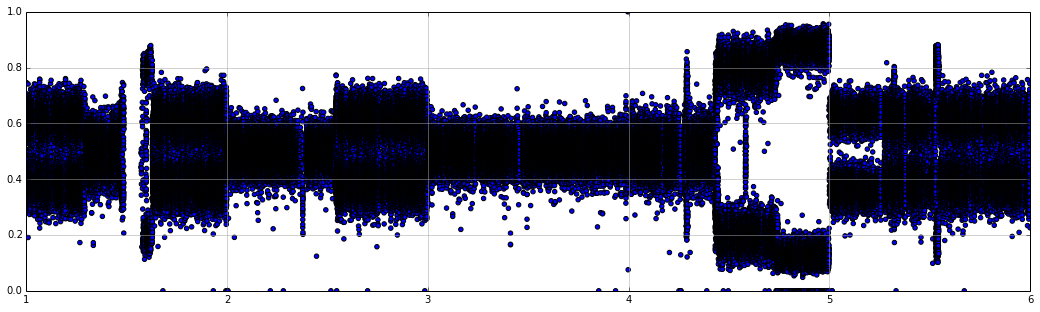

In [40]:
c = 1
pos = 149000000
print cd.chromosomeLength[str(c)],round(pos/float(cd.chromosomeLength[str(c)]),6)
#offset = 0.0001
#fractionMin = pos/float(cd.chromosomeLength[str(c)])-offset
#fractionMax = pos/float(cd.chromosomeLength[str(c)])+offset
fractionMin = 0
fractionMax = 5
minNormalAF = 0.45
maxNormalAF = 0.55
minNormalDepth = 30
maxNormalDepth = 50
df['mbaf']=0.5-abs(df.tumorAF-0.5)
dfHet = df[(df['variantType']=="SNP")&(df['normalSGT']=="0/1")&(df['normalAF']>minNormalAF)&(df['normalAF']<maxNormalAF)&(df['normalDP']>minNormalDepth)&(df['normalDP']<maxNormalDepth)&(df.chromFrac>c+fractionMin)&(df.chromFrac<c+fractionMax)]
plt.figure(figsize=[18,5])
plt.scatter(dfHet.chromFrac, dfHet.tumorAF)
plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.axis([c+fractionMin, c+fractionMax,0,1])
plt.show()

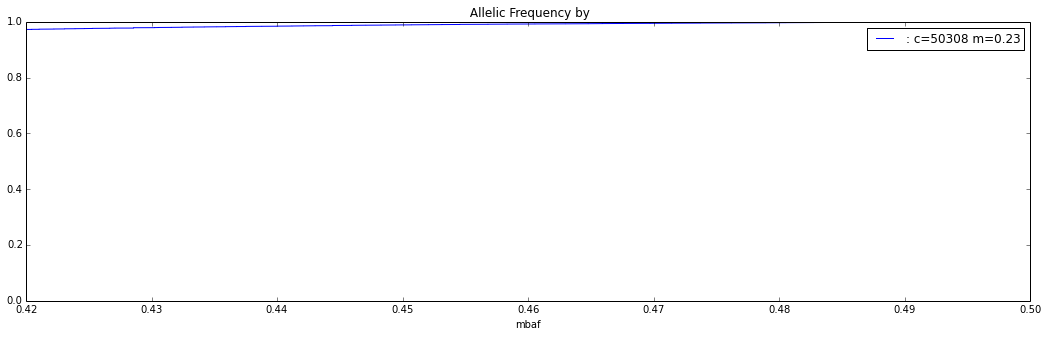

In [277]:
ser = dfHet['mbaf']
ser = ser.sort_values()
cum_dist = np.linspace(0.,1.,len(ser))
ser_cdf = pd.Series(cum_dist, index=ser,name=": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by ",figsize=[18,5],xlim=[0.42,0.5])

In [170]:
#df[(df['variantType']=="SNP")&(df['normalSGT']=='0/0')&(df['tumorSGT']=='0/1')].head(100)

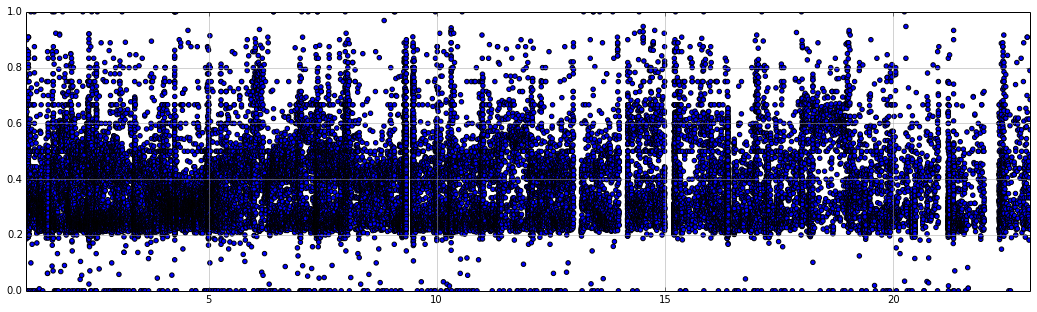

In [84]:
############### SOMATIC AF ##############
c = 1
#pos = 190202000
#print round(pos/float(cd.chromosomeLength[str(c)]),6)
#offset = 0.0001
#fractionMin = pos/float(cd.chromosomeLength[str(c)])-offset
#fractionMax = pos/float(cd.chromosomeLength[str(c)])+offset
fractionMin = 0
fractionMax = 22
minNormalAF = -1
maxNormalAF = 1
minNormalDepth = 1
maxNormalDepth = 5000
df['mbaf']=0.5-abs(df.tumorAF-0.5)
dfSom = df[(df['variantType']=="SNP")&(df['tumorQS']>6)&(df['normalSGT']=='0/0')&(df['tumorSGT']=='0/1')&(df['normalAF']>minNormalAF)&(df['normalAF']<maxNormalAF)&(df['normalDP']>minNormalDepth)&(df['normalDP']<maxNormalDepth)&(df.chromFrac>c+fractionMin)&(df.chromFrac<c+fractionMax)]
plt.figure(figsize=[18,5])
plt.scatter(dfSom.chromFrac, dfSom.tumorAF)
plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.axis([c+fractionMin, c+fractionMax,0, 1.0])
plt.show()

In [ ]:
ser = dfSom['tumorAF']
ser = ser.sort_values()
cum_dist = np.linspace(0.,1.,len(ser))
ser_cdf = pd.Series(cum_dist, index=ser,name=": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by ",figsize=[18,10],xlim=[0,0.5])